# Hybrid Fusion Ensemble: ML + DL Integration
## 4 Fusion Strategies for Fraud Detection

**Project:** Hybrid Fraud Shield  
**Author:** Kiyas Mahmud  
**Date:** November 8, 2025

---

## Objective

Combine predictions from 5 ML models and 6 DL models using 4 different fusion strategies:

1. **Voting Ensemble** - Hard voting and soft voting
2. **Weighted Averaging** - Weighted by model performance
3. **Stacking** - Meta-learner trained on base model predictions
4. **Top-K Selection** - Select best K models dynamically

## Base Models

**ML Models (5):**
- Logistic Regression
- Random Forest
- XGBoost
- CatBoost
- LightGBM

**DL Models (6):**
- FNN (Feedforward Neural Network)
- CNN (Convolutional Neural Network)
- LSTM (Long Short-Term Memory)
- BiLSTM (Bidirectional LSTM)
- Hybrid (CNN-BiLSTM)
- Autoencoder

---

## Step 1: Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression

# Deep Learning
import tensorflow as tf
from tensorflow import keras

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("="*80)
print("HYBRID FUSION ENSEMBLE - 4 STRATEGIES")
print("="*80)
print(f"Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"TensorFlow version: {tf.__version__}")
print("="*80)

## Step 2: Load Test Data and Labels

In [ ]:
print("\n" + "="*80)
print("LOADING DATA")
print("="*80)

# Load test data
X_test_scaled = pd.read_csv('../../data/final_processed_data/X_test_scaled.csv')
y_test = pd.read_csv('../../data/final_processed_data/y_test.csv').values.ravel()

print(f"\nTest data loaded:")
print(f"  Samples: {len(X_test_scaled):,}")
print(f"  Features: {X_test_scaled.shape[1]}")
print(f"  Fraud cases: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")
print(f"  Normal cases: {(y_test == 0).sum():,} ({(y_test == 0).mean()*100:.2f}%)")
print("="*80)

## Step 3: Load ML Models

In [ ]:
print("\n" + "="*80)
print("LOADING ML MODELS")
print("="*80)

ml_models_dir = '../ml/saved_models'

ml_models = {
    'Logistic Regression': joblib.load(f'{ml_models_dir}/logistic_regression_model.pkl'),
    'Random Forest': joblib.load(f'{ml_models_dir}/random_forest_model.pkl'),
    'XGBoost': joblib.load(f'{ml_models_dir}/xgboost_model.pkl'),
    'CatBoost': joblib.load(f'{ml_models_dir}/catboost_model.pkl'),
    'LightGBM': joblib.load(f'{ml_models_dir}/lightgbm_model.pkl')
}

print(f"\nML Models loaded: {len(ml_models)}")
for name in ml_models.keys():
    print(f"  - {name}")
print("="*80)

## Step 4: Load DL Models

In [ ]:
print("\n" + "="*80)
print("LOADING DL MODELS")
print("="*80)

dl_models_dir = '../dl/saved_models'

dl_models = {
    'FNN': keras.models.load_model(f'{dl_models_dir}/fnn_model.keras'),
    'CNN': keras.models.load_model(f'{dl_models_dir}/cnn_model.keras'),
    'LSTM': keras.models.load_model(f'{dl_models_dir}/lstm_model.keras'),
    'BiLSTM': keras.models.load_model(f'{dl_models_dir}/bilstm_model.keras'),
    'Hybrid (CNN-BiLSTM)': keras.models.load_model(f'{dl_models_dir}/cnn_bilstm_model.keras'),
    'Autoencoder': keras.models.load_model(f'{dl_models_dir}/autoencoder_model.keras')
}

print(f"\nDL Models loaded: {len(dl_models)}")
for name in dl_models.keys():
    print(f"  - {name}")

print(f"\n{'-'*80}")
print(f"TOTAL BASE MODELS: {len(ml_models) + len(dl_models)}")
print(f"  ML: {len(ml_models)} | DL: {len(dl_models)}")
print("="*80)

## Step 5: Generate Predictions from All Base Models

In [ ]:
print("\n" + "="*80)
print("GENERATING BASE MODEL PREDICTIONS")
print("="*80)

# ML predictions
print("\nGenerating ML predictions...")
ml_predictions = {}
ml_predictions_proba = {}

for name, model in ml_models.items():
    pred = model.predict(X_test_scaled)
    pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    ml_predictions[name] = pred
    ml_predictions_proba[name] = pred_proba
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"  {name:<25} - Accuracy: {acc:.4f} | F1: {f1:.4f}")

# DL predictions
print("\nGenerating DL predictions...")
dl_predictions = {}
dl_predictions_proba = {}

X_test_values = X_test_scaled.values

for name, model in dl_models.items():
    # Reshape for sequential models
    if name in ['LSTM', 'BiLSTM', 'Hybrid (CNN-BiLSTM)']:
        X_input = X_test_values.reshape(X_test_values.shape[0], X_test_values.shape[1], 1)
    else:
        X_input = X_test_values
    
    # Special handling for Autoencoder
    if name == 'Autoencoder':
        reconstructed = model.predict(X_input, verbose=0)
        reconstruction_error = np.mean((X_test_values - reconstructed) ** 2, axis=1)
        # Normalize to [0, 1]
        pred_proba = (reconstruction_error - reconstruction_error.min()) / \
                     (reconstruction_error.max() - reconstruction_error.min())
    else:
        pred_proba = model.predict(X_input, verbose=0).ravel()
    
    pred = (pred_proba >= 0.5).astype(int)
    dl_predictions[name] = pred
    dl_predictions_proba[name] = pred_proba
    
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"  {name:<25} - Accuracy: {acc:.4f} | F1: {f1:.4f}")

# Combine all predictions
all_predictions = {**ml_predictions, **dl_predictions}
all_predictions_proba = {**ml_predictions_proba, **dl_predictions_proba}

print(f"\n{'-'*80}")
print(f"Total predictions generated: {len(all_predictions)}")
print("="*80)

## Step 6: Calculate Individual Model Performance

In [ ]:
print("\n" + "="*80)
print("INDIVIDUAL MODEL PERFORMANCE")
print("="*80)

model_performance = []

for name in all_predictions.keys():
    pred = all_predictions[name]
    pred_proba = all_predictions_proba[name]
    
    perf = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1-Score': f1_score(y_test, pred),
        'ROC-AUC': roc_auc_score(y_test, pred_proba)
    }
    model_performance.append(perf)

performance_df = pd.DataFrame(model_performance)
performance_df = performance_df.sort_values('F1-Score', ascending=False)

print(f"\n{'Model':<30}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC-AUC'}")
print("-"*80)
for _, row in performance_df.iterrows():
    print(f"{row['Model']:<30}{row['Accuracy']:<12.4f}{row['Precision']:<12.4f}{row['Recall']:<12.4f}{row['F1-Score']:<12.4f}{row['ROC-AUC']:.4f}")

print("\n" + "-"*80)
print(f"Best Model (by F1-Score): {performance_df.iloc[0]['Model']}")
print(f"Best F1-Score: {performance_df.iloc[0]['F1-Score']:.4f}")
print("="*80)

# Save performance
os.makedirs('fusion_results', exist_ok=True)
performance_df.to_csv('fusion_results/individual_model_performance.csv', index=False)
print(f"\nSaved: fusion_results/individual_model_performance.csv")

---

# FUSION STRATEGY 1: VOTING ENSEMBLE

## Hard Voting and Soft Voting

## Step 7.1: Hard Voting (Majority Vote)

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 1A: HARD VOTING")
print("="*80)

# Convert predictions to array
predictions_array = np.array([all_predictions[name] for name in all_predictions.keys()]).T

# Hard voting: majority vote
hard_voting_pred = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=predictions_array)

# Calculate metrics
hv_accuracy = accuracy_score(y_test, hard_voting_pred)
hv_precision = precision_score(y_test, hard_voting_pred)
hv_recall = recall_score(y_test, hard_voting_pred)
hv_f1 = f1_score(y_test, hard_voting_pred)

print(f"\nHard Voting Results:")
print("-"*80)
print(f"  Accuracy:  {hv_accuracy:.4f}")
print(f"  Precision: {hv_precision:.4f}")
print(f"  Recall:    {hv_recall:.4f}")
print(f"  F1-Score:  {hv_f1:.4f}")

# Confusion matrix
hv_cm = confusion_matrix(y_test, hard_voting_pred)
print(f"\nConfusion Matrix:")
print(f"  TN: {hv_cm[0,0]:,} | FP: {hv_cm[0,1]:,}")
print(f"  FN: {hv_cm[1,0]:,} | TP: {hv_cm[1,1]:,}")
print("="*80)

## Step 7.2: Soft Voting (Average Probabilities)

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 1B: SOFT VOTING")
print("="*80)

# Convert probabilities to array
probabilities_array = np.array([all_predictions_proba[name] for name in all_predictions_proba.keys()]).T

# Soft voting: average probabilities
soft_voting_proba = np.mean(probabilities_array, axis=1)
soft_voting_pred = (soft_voting_proba >= 0.5).astype(int)

# Calculate metrics
sv_accuracy = accuracy_score(y_test, soft_voting_pred)
sv_precision = precision_score(y_test, soft_voting_pred)
sv_recall = recall_score(y_test, soft_voting_pred)
sv_f1 = f1_score(y_test, soft_voting_pred)
sv_roc_auc = roc_auc_score(y_test, soft_voting_proba)

print(f"\nSoft Voting Results:")
print("-"*80)
print(f"  Accuracy:  {sv_accuracy:.4f}")
print(f"  Precision: {sv_precision:.4f}")
print(f"  Recall:    {sv_recall:.4f}")
print(f"  F1-Score:  {sv_f1:.4f}")
print(f"  ROC-AUC:   {sv_roc_auc:.4f}")

# Confusion matrix
sv_cm = confusion_matrix(y_test, soft_voting_pred)
print(f"\nConfusion Matrix:")
print(f"  TN: {sv_cm[0,0]:,} | FP: {sv_cm[0,1]:,}")
print(f"  FN: {sv_cm[1,0]:,} | TP: {sv_cm[1,1]:,}")
print("="*80)

---

# FUSION STRATEGY 2: WEIGHTED AVERAGING

## Weight models by their F1-Score performance

## Step 8: Weighted Averaging by F1-Score

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 2: WEIGHTED AVERAGING")
print("="*80)

# Calculate weights based on F1-Score
weights = np.array([f1_score(y_test, all_predictions[name]) for name in all_predictions.keys()])
weights = weights / weights.sum()  # Normalize

print("\nModel Weights (based on F1-Score):")
print("-"*80)
for i, name in enumerate(all_predictions.keys()):
    print(f"  {name:<30} Weight: {weights[i]:.4f}")

# Weighted average of probabilities
weighted_avg_proba = np.average(probabilities_array, axis=1, weights=weights)
weighted_avg_pred = (weighted_avg_proba >= 0.5).astype(int)

# Calculate metrics
wa_accuracy = accuracy_score(y_test, weighted_avg_pred)
wa_precision = precision_score(y_test, weighted_avg_pred)
wa_recall = recall_score(y_test, weighted_avg_pred)
wa_f1 = f1_score(y_test, weighted_avg_pred)
wa_roc_auc = roc_auc_score(y_test, weighted_avg_proba)

print(f"\nWeighted Averaging Results:")
print("-"*80)
print(f"  Accuracy:  {wa_accuracy:.4f}")
print(f"  Precision: {wa_precision:.4f}")
print(f"  Recall:    {wa_recall:.4f}")
print(f"  F1-Score:  {wa_f1:.4f}")
print(f"  ROC-AUC:   {wa_roc_auc:.4f}")

# Confusion matrix
wa_cm = confusion_matrix(y_test, weighted_avg_pred)
print(f"\nConfusion Matrix:")
print(f"  TN: {wa_cm[0,0]:,} | FP: {wa_cm[0,1]:,}")
print(f"  FN: {wa_cm[1,0]:,} | TP: {wa_cm[1,1]:,}")
print("="*80)

---

# FUSION STRATEGY 3: STACKING ENSEMBLE

## Train a meta-learner on base model predictions

## Step 9: Stacking with Logistic Regression Meta-Learner

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 3: STACKING ENSEMBLE")
print("="*80)

# Note: We need validation set predictions to train the meta-learner
# For now, we'll use the saved meta-learner from the meta_learner_stacking notebook

try:
    # Try to load the trained meta-learner
    meta_learner = joblib.load('saved_models/meta_learner.pkl')
    
    # Make predictions using base model probabilities
    stacking_proba = meta_learner.predict_proba(probabilities_array)[:, 1]
    stacking_pred = (stacking_proba >= 0.5).astype(int)
    
    # Calculate metrics
    st_accuracy = accuracy_score(y_test, stacking_pred)
    st_precision = precision_score(y_test, stacking_pred)
    st_recall = recall_score(y_test, stacking_pred)
    st_f1 = f1_score(y_test, stacking_pred)
    st_roc_auc = roc_auc_score(y_test, stacking_proba)
    
    print(f"\nStacking Results (using trained meta-learner):")
    print("-"*80)
    print(f"  Accuracy:  {st_accuracy:.4f}")
    print(f"  Precision: {st_precision:.4f}")
    print(f"  Recall:    {st_recall:.4f}")
    print(f"  F1-Score:  {st_f1:.4f}")
    print(f"  ROC-AUC:   {st_roc_auc:.4f}")
    
    # Confusion matrix
    st_cm = confusion_matrix(y_test, stacking_pred)
    print(f"\nConfusion Matrix:")
    print(f"  TN: {st_cm[0,0]:,} | FP: {st_cm[0,1]:,}")
    print(f"  FN: {st_cm[1,0]:,} | TP: {st_cm[1,1]:,}")
    
    stacking_available = True
    
except FileNotFoundError:
    print("\nMeta-learner not found. Please run 03_meta_learner_stacking.ipynb first.")
    print("Stacking ensemble results will not be available.")
    stacking_available = False
    st_accuracy = st_precision = st_recall = st_f1 = st_roc_auc = 0

print("="*80)

---

# FUSION STRATEGY 4: TOP-K SELECTION

## Select best K models and average their predictions

## Step 10: Top-K Selection (K=3, 5, 7)

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGY 4: TOP-K SELECTION")
print("="*80)

# Sort models by F1-Score
sorted_models = performance_df.sort_values('F1-Score', ascending=False)

topk_results = {}

for k in [3, 5, 7]:
    print(f"\nTop-{k} Model Selection:")
    print("-"*80)
    
    # Get top k models
    top_k_models = sorted_models.head(k)['Model'].tolist()
    
    print(f"Selected models:")
    for i, name in enumerate(top_k_models, 1):
        f1 = sorted_models[sorted_models['Model'] == name]['F1-Score'].values[0]
        print(f"  {i}. {name:<30} (F1: {f1:.4f})")
    
    # Average probabilities of top k models
    top_k_probas = np.array([all_predictions_proba[name] for name in top_k_models]).T
    topk_proba = np.mean(top_k_probas, axis=1)
    topk_pred = (topk_proba >= 0.5).astype(int)
    
    # Calculate metrics
    tk_accuracy = accuracy_score(y_test, topk_pred)
    tk_precision = precision_score(y_test, topk_pred)
    tk_recall = recall_score(y_test, topk_pred)
    tk_f1 = f1_score(y_test, topk_pred)
    tk_roc_auc = roc_auc_score(y_test, topk_proba)
    
    print(f"\nTop-{k} Results:")
    print(f"  Accuracy:  {tk_accuracy:.4f}")
    print(f"  Precision: {tk_precision:.4f}")
    print(f"  Recall:    {tk_recall:.4f}")
    print(f"  F1-Score:  {tk_f1:.4f}")
    print(f"  ROC-AUC:   {tk_roc_auc:.4f}")
    
    # Store results
    topk_results[f'Top-{k}'] = {
        'accuracy': tk_accuracy,
        'precision': tk_precision,
        'recall': tk_recall,
        'f1_score': tk_f1,
        'roc_auc': tk_roc_auc,
        'models': top_k_models
    }

print("\n" + "="*80)

---

# COMPARISON OF ALL FUSION STRATEGIES

## Step 11: Compare All Fusion Strategies

In [ ]:
print("\n" + "="*80)
print("FUSION STRATEGIES COMPARISON")
print("="*80)

# Compile results
fusion_results = [
    {
        'Strategy': 'Hard Voting',
        'Accuracy': hv_accuracy,
        'Precision': hv_precision,
        'Recall': hv_recall,
        'F1-Score': hv_f1,
        'ROC-AUC': np.nan  # Hard voting doesn't have probabilities
    },
    {
        'Strategy': 'Soft Voting',
        'Accuracy': sv_accuracy,
        'Precision': sv_precision,
        'Recall': sv_recall,
        'F1-Score': sv_f1,
        'ROC-AUC': sv_roc_auc
    },
    {
        'Strategy': 'Weighted Averaging',
        'Accuracy': wa_accuracy,
        'Precision': wa_precision,
        'Recall': wa_recall,
        'F1-Score': wa_f1,
        'ROC-AUC': wa_roc_auc
    }
]

if stacking_available:
    fusion_results.append({
        'Strategy': 'Stacking',
        'Accuracy': st_accuracy,
        'Precision': st_precision,
        'Recall': st_recall,
        'F1-Score': st_f1,
        'ROC-AUC': st_roc_auc
    })

# Add Top-K results
for k, results in topk_results.items():
    fusion_results.append({
        'Strategy': k,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'ROC-AUC': results['roc_auc']
    })

fusion_df = pd.DataFrame(fusion_results)
fusion_df = fusion_df.sort_values('F1-Score', ascending=False)

print(f"\n{'Strategy':<25}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1-Score':<12}{'ROC-AUC'}")
print("-"*80)
for _, row in fusion_df.iterrows():
    roc = f"{row['ROC-AUC']:.4f}" if not np.isnan(row['ROC-AUC']) else "N/A"
    print(f"{row['Strategy']:<25}{row['Accuracy']:<12.4f}{row['Precision']:<12.4f}{row['Recall']:<12.4f}{row['F1-Score']:<12.4f}{roc}")

print("\n" + "-"*80)
print(f"Best Strategy (by F1-Score): {fusion_df.iloc[0]['Strategy']}")
print(f"Best F1-Score: {fusion_df.iloc[0]['F1-Score']:.4f}")
print("="*80)

# Save results
fusion_df.to_csv('fusion_results/fusion_strategies_comparison.csv', index=False)
print(f"\nSaved: fusion_results/fusion_strategies_comparison.csv")

## Step 12: Visualize Fusion Strategy Comparison

In [ ]:
print("\n" + "="*80)
print("CREATING COMPARISON VISUALIZATIONS")
print("="*80)

# Create comparison bar charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by current metric
    sorted_df = fusion_df.sort_values(metric, ascending=True)
    
    ax.barh(sorted_df['Strategy'], sorted_df[metric], color=color, alpha=0.7)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('fusion_results/fusion_strategies_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: fusion_results/fusion_strategies_comparison.png")
print("="*80)

## Step 13: ROC-AUC Comparison

In [ ]:
print("\n" + "="*80)
print("ROC-AUC COMPARISON")
print("="*80)

# Filter strategies with ROC-AUC scores
roc_df = fusion_df[~fusion_df['ROC-AUC'].isna()].copy()
roc_df = roc_df.sort_values('ROC-AUC', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(roc_df['Strategy'], roc_df['ROC-AUC'], color='purple', alpha=0.7)
plt.xlabel('ROC-AUC Score', fontsize=12, fontweight='bold')
plt.title('ROC-AUC Comparison Across Fusion Strategies', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(roc_df['ROC-AUC']):
    plt.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('fusion_results/roc_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nSaved: fusion_results/roc_auc_comparison.png")
print("="*80)

## Step 14: Generate Summary Report

In [ ]:
print("\n" + "="*80)
print("GENERATING SUMMARY REPORT")
print("="*80)

# Create comprehensive summary
summary_report = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_samples': int(len(y_test)),
    'base_models': {
        'ml_models': len(ml_models),
        'dl_models': len(dl_models),
        'total': len(ml_models) + len(dl_models)
    },
    'fusion_strategies': {
        'voting': {
            'hard_voting': {
                'accuracy': float(hv_accuracy),
                'precision': float(hv_precision),
                'recall': float(hv_recall),
                'f1_score': float(hv_f1)
            },
            'soft_voting': {
                'accuracy': float(sv_accuracy),
                'precision': float(sv_precision),
                'recall': float(sv_recall),
                'f1_score': float(sv_f1),
                'roc_auc': float(sv_roc_auc)
            }
        },
        'weighted_averaging': {
            'accuracy': float(wa_accuracy),
            'precision': float(wa_precision),
            'recall': float(wa_recall),
            'f1_score': float(wa_f1),
            'roc_auc': float(wa_roc_auc)
        },
        'stacking': {
            'available': stacking_available,
            'accuracy': float(st_accuracy) if stacking_available else None,
            'precision': float(st_precision) if stacking_available else None,
            'recall': float(st_recall) if stacking_available else None,
            'f1_score': float(st_f1) if stacking_available else None,
            'roc_auc': float(st_roc_auc) if stacking_available else None
        },
        'top_k': topk_results
    },
    'best_strategy': {
        'name': fusion_df.iloc[0]['Strategy'],
        'f1_score': float(fusion_df.iloc[0]['F1-Score']),
        'accuracy': float(fusion_df.iloc[0]['Accuracy']),
        'precision': float(fusion_df.iloc[0]['Precision']),
        'recall': float(fusion_df.iloc[0]['Recall'])
    }
}

# Save JSON report
with open('fusion_results/fusion_summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print(f"\nSaved: fusion_results/fusion_summary_report.json")

# Generate text report
text_report = f"""
{'='*80}
HYBRID FUSION ENSEMBLE - SUMMARY REPORT
{'='*80}

Analysis Date: {summary_report['analysis_date']}
Test Samples: {summary_report['test_samples']:,}

BASE MODELS
{'-'*80}
ML Models: {summary_report['base_models']['ml_models']}
DL Models: {summary_report['base_models']['dl_models']}
Total: {summary_report['base_models']['total']}

BEST FUSION STRATEGY
{'-'*80}
Strategy: {summary_report['best_strategy']['name']}
F1-Score: {summary_report['best_strategy']['f1_score']:.4f}
Accuracy: {summary_report['best_strategy']['accuracy']:.4f}
Precision: {summary_report['best_strategy']['precision']:.4f}
Recall: {summary_report['best_strategy']['recall']:.4f}

ALL FUSION STRATEGIES
{'-'*80}
"""

for _, row in fusion_df.iterrows():
    text_report += f"\n{row['Strategy']}:\n"
    text_report += f"  Accuracy:  {row['Accuracy']:.4f}\n"
    text_report += f"  Precision: {row['Precision']:.4f}\n"
    text_report += f"  Recall:    {row['Recall']:.4f}\n"
    text_report += f"  F1-Score:  {row['F1-Score']:.4f}\n"
    if not np.isnan(row['ROC-AUC']):
        text_report += f"  ROC-AUC:   {row['ROC-AUC']:.4f}\n"

text_report += f"""
{'-'*80}
All results saved to: fusion_results/
{'='*80}
"""

# Save text report
with open('fusion_results/fusion_summary_report.txt', 'w') as f:
    f.write(text_report)

print(f"Saved: fusion_results/fusion_summary_report.txt")

# Print report
print(text_report)

print("\n" + "="*80)
print("HYBRID FUSION ENSEMBLE ANALYSIS COMPLETE")
print("="*80)
print(f"\nAll results saved to: fusion_results/")
print(f"  - individual_model_performance.csv")
print(f"  - fusion_strategies_comparison.csv")
print(f"  - fusion_strategies_comparison.png")
print(f"  - roc_auc_comparison.png")
print(f"  - fusion_summary_report.json")
print(f"  - fusion_summary_report.txt")
print("="*80)

---

## Analysis Complete

### Summary of Results

This notebook implemented and compared 4 fusion strategies:

1. **Voting Ensemble**
   - Hard Voting: Majority vote
   - Soft Voting: Average probabilities

2. **Weighted Averaging**
   - Models weighted by F1-Score performance

3. **Stacking**
   - Meta-learner trained on base model predictions
   - (Requires running 03_meta_learner_stacking.ipynb first)

4. **Top-K Selection**
   - Select best K models (K=3, 5, 7)
   - Average their predictions

### Key Findings

- The best fusion strategy varies by metric
- Ensemble methods typically outperform individual models
- Combining ML and DL models provides robust predictions

### Next Steps

1. Analyze results to choose optimal fusion strategy
2. Fine-tune hyperparameters for selected strategy
3. Deploy best ensemble model to production

---

# ML + DL Hybrid Fusion Ensemble
## Advanced Fraud Detection - Combining Machine Learning and Deep Learning

**Project:** Hybrid Fraud Shield  
**Author:** Kiyas Mahmud  
**Date:** November 7, 2025

---

## 📋 Overview

This notebook implements advanced ensemble fusion strategies to combine:
- **5 Machine Learning Models:** Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM
- **6 Deep Learning Models:** FNN, CNN, LSTM, BiLSTM, Hybrid (CNN-BiLSTM), Autoencoder

### 🎯 Objectives
1. Load all pre-trained ML and DL models
2. Generate predictions from all 11 base models
3. Implement 4 fusion strategies:
   - **Voting Ensemble** (Hard & Soft)
   - **Weighted Averaging** (Performance-based)
   - **Stacking Ensemble** (Meta-learner)
   - **Custom Fusion** (Optimized combination)
4. Compare all strategies and select the best
5. Optimize threshold for maximum F1-score
6. Evaluate on test set and save final model

### 💡 Expected Benefits
- Better generalization from diverse model types
- Reduced overfitting through ensemble diversity
- Higher F1-Score and ROC-AUC
- More robust fraud detection

---

## 1️⃣ Import Required Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from datetime import datetime

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, average_precision_score,
    precision_recall_curve, confusion_matrix, classification_report
)
import joblib

# DL libraries
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# Plot settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

✓ All libraries imported successfully
TensorFlow version: 2.18.1
Keras version: 3.11.2


## 2️⃣ Load and Prepare Data

Load the fraud detection dataset and create train/validation/test splits (60/20/20).  
Prepare both scaled and unscaled versions for different model requirements.

In [2]:
# Load dataset
data_path = r'../../data/train_72_features.csv'
df = pd.read_csv(data_path)

print(f"Dataset loaded: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Fraud cases: {df['isFraud'].sum():,} ({df['isFraud'].mean()*100:.2f}%)")
print(f"Normal cases: {(~df['isFraud'].astype(bool)).sum():,}")

# Separate features and target
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# First split: 60% train, 40% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# Second split: 20% validation, 20% test (from the 40% temp)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n{'='*60}")
print(f"Data Split (Stratified):")
print(f"{'='*60}")
print(f"Train: {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"  - Fraud: {y_train.sum():,} ({y_train.mean()*100:.2f}%)")
print(f"Val:   {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"  - Fraud: {y_val.sum():,} ({y_val.mean()*100:.2f}%)")
print(f"Test:  {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")
print(f"  - Fraud: {y_test.sum():,} ({y_test.mean()*100:.2f}%)")

# Scale data for DL models and Logistic Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# Keep unscaled versions for tree-based models
X_train_unscaled = X_train.copy()
X_val_unscaled = X_val.copy()
X_test_unscaled = X_test.copy()

print(f"\n✓ Data prepared with scaled and unscaled versions")

Dataset loaded: (590540, 72)
Features: 71
Fraud cases: 20,663 (3.50%)
Normal cases: 569,877

Data Split (Stratified):
Train: 354,324 samples (60.0%)
  - Fraud: 12,398 (3.50%)
Val:   118,108 samples (20.0%)
  - Fraud: 4,133 (3.50%)
Test:  118,108 samples (20.0%)
  - Fraud: 4,132 (3.50%)

✓ Data prepared with scaled and unscaled versions


## 3️⃣ Load Pre-trained ML Models

Load all 5 trained machine learning models from the `model/ml/models/` directory.

In [3]:
# Define ML models directory
ml_models_dir = r'../ml/models'

# ML model files
ml_model_files = {
    'Logistic Regression': 'logistic_regression_tuned_72features.pkl',
    'Random Forest': 'random_forest_tuned_72features.pkl',
    'XGBoost': 'xgboost_tuned_72features.pkl',
    'CatBoost': 'catboost_tuned_72features.pkl',
    'LightGBM': 'lightgbm_tuned_72features.pkl'
}

# Load ML models
ml_models = {}
print(f"{'='*60}")
print(f"Loading Machine Learning Models")
print(f"{'='*60}")

for name, filename in ml_model_files.items():
    model_path = os.path.join(ml_models_dir, filename)
    try:
        ml_models[name] = joblib.load(model_path)
        print(f"✓ Loaded: {name}")
    except Exception as e:
        print(f"✗ Error loading {name}: {e}")

print(f"\n✓ Total ML models loaded: {len(ml_models)}/5")

Loading Machine Learning Models
✓ Loaded: Logistic Regression
✓ Loaded: Random Forest
✓ Loaded: XGBoost
✓ Loaded: CatBoost
✓ Loaded: LightGBM

✓ Total ML models loaded: 5/5


## 4️⃣ Load Pre-trained DL Models

Load all 6 trained deep learning models from the `model/dl/saved_models/` directory.

In [4]:
# Define DL models directory
dl_models_dir = r'../dl/saved_models'

# DL model files
dl_model_files = {
    'FNN': 'fnn_tuned.keras',
    'CNN': 'cnn_tuned.keras',
    'LSTM': 'lstm_tuned.keras',
    'BiLSTM': 'bilstm_tuned.keras',
    'Hybrid': 'hybrid_tuned.keras',  # CNN-BiLSTM
    'Autoencoder': 'autoencoder_tuned.keras'
}

# Load DL models
dl_models = {}
print(f"{'='*60}")
print(f"Loading Deep Learning Models")
print(f"{'='*60}")

for name, filename in dl_model_files.items():
    model_path = os.path.join(dl_models_dir, filename)
    try:
        dl_models[name] = load_model(model_path)
        print(f"✓ Loaded: {name}")
    except Exception as e:
        print(f"✗ Error loading {name}: {e}")

print(f"\n✓ Total DL models loaded: {len(dl_models)}/6")
print(f"\n{'='*60}")
print(f"TOTAL MODELS LOADED: {len(ml_models) + len(dl_models)}/11")
print(f"{'='*60}")

Loading Deep Learning Models
✓ Loaded: FNN
✓ Loaded: CNN
✓ Loaded: LSTM
✓ Loaded: BiLSTM
✓ Loaded: Hybrid
✓ Loaded: Autoencoder

✓ Total DL models loaded: 6/6

TOTAL MODELS LOADED: 11/11


## 5️⃣ Generate Predictions from All Base Models

Generate probability predictions from all 11 models on the validation set.  
**Important:** 
- DL models and Logistic Regression use scaled data
- Tree-based models (RF, XGBoost, CatBoost, LightGBM) use unscaled data
- Autoencoder uses reconstruction error as anomaly score

In [5]:
print(f"{'='*60}")
print(f"Generating Predictions from Base Models")
print(f"{'='*60}\n")

# Dictionary to store all predictions
all_predictions_val = {}

# ML Model Predictions
print("ML Models:")
print("-" * 60)

for name, model in ml_models.items():
    # Use scaled data for Logistic Regression, unscaled for tree models
    if name == 'Logistic Regression':
        X_input = X_val_scaled
    else:
        X_input = X_val_unscaled
    
    # Get probability for fraud class (class 1)
    proba = model.predict_proba(X_input)[:, 1]
    all_predictions_val[f"ML_{name}"] = proba
    print(f"✓ {name}: {proba.shape[0]} predictions")

# DL Model Predictions
print("\nDL Models:")
print("-" * 60)

for name, model in dl_models.items():
    # All DL models use scaled data
    if name == 'Autoencoder':
        # For autoencoder, use reconstruction error as anomaly score
        reconstructed = model.predict(X_val_scaled, verbose=0)
        reconstruction_error = np.mean((X_val_scaled.values - reconstructed) ** 2, axis=1)
        # Normalize to [0, 1]
        proba = (reconstruction_error - reconstruction_error.min()) / \
                (reconstruction_error.max() - reconstruction_error.min())
    else:
        # Regular prediction
        proba = model.predict(X_val_scaled, verbose=0).ravel()
    
    all_predictions_val[f"DL_{name}"] = proba
    print(f"✓ {name}: {proba.shape[0]} predictions")

print(f"\n{'='*60}")
print(f"✓ Total predictions generated: {len(all_predictions_val)}/11")
print(f"{'='*60}")

# Create DataFrame for easy manipulation
predictions_df = pd.DataFrame(all_predictions_val)
print(f"\nPredictions DataFrame shape: {predictions_df.shape}")
print(f"\nSample predictions (first 5 rows):")
print(predictions_df.head())

Generating Predictions from Base Models

ML Models:
------------------------------------------------------------
✓ Logistic Regression: 118108 predictions
✓ Random Forest: 118108 predictions
✓ XGBoost: 118108 predictions
✓ CatBoost: 118108 predictions
✓ LightGBM: 118108 predictions

DL Models:
------------------------------------------------------------
✓ FNN: 118108 predictions
✓ CNN: 118108 predictions
✓ LSTM: 118108 predictions
✓ BiLSTM: 118108 predictions
✓ Hybrid: 118108 predictions
✓ Autoencoder: 118108 predictions

✓ Total predictions generated: 11/11

Predictions DataFrame shape: (118108, 11)

Sample predictions (first 5 rows):
   ML_Logistic Regression  ML_Random Forest  ML_XGBoost  ML_CatBoost  \
0                0.401269          0.246053    0.008808     0.088858   
1                0.489219          0.118177    0.002942     0.326018   
2                0.308734          0.059567    0.003002     0.035404   
3                0.431299          0.084274    0.206649     0.436112

## 6️⃣ Evaluate Individual Model Performance

Establish baseline performance for each of the 11 models before fusion.

In [6]:
def evaluate_model(y_true, y_pred_proba, model_name, threshold=0.5):
    """
    Evaluate model performance with comprehensive metrics
    """
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'PR-AUC': average_precision_score(y_true, y_pred_proba)
    }
    
    return metrics

# Evaluate all base models
print(f"{'='*60}")
print(f"Individual Model Performance (Baseline)")
print(f"{'='*60}\n")

baseline_results = []

for model_name, predictions in all_predictions_val.items():
    metrics = evaluate_model(y_val, predictions, model_name)
    baseline_results.append(metrics)
    
    # Print results
    print(f"{model_name}:")
    print(f"  F1-Score: {metrics['F1-Score']:.4f} | "
          f"ROC-AUC: {metrics['ROC-AUC']:.4f} | "
          f"Precision: {metrics['Precision']:.4f} | "
          f"Recall: {metrics['Recall']:.4f}")

# Create DataFrame and sort by F1-Score
baseline_df = pd.DataFrame(baseline_results)
baseline_df = baseline_df.sort_values('F1-Score', ascending=False)

print(f"\n{'='*60}")
print(f"Top 5 Individual Models (by F1-Score):")
print(f"{'='*60}")
print(baseline_df[['Model', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall']].head().to_string(index=False))

# Store for later comparison
best_individual_f1 = baseline_df['F1-Score'].max()
best_individual_model = baseline_df.iloc[0]['Model']
print(f"\n🏆 Best Individual Model: {best_individual_model} (F1: {best_individual_f1:.4f})")

Individual Model Performance (Baseline)

ML_Logistic Regression:
  F1-Score: 0.1911 | ROC-AUC: 0.7699 | Precision: 0.1160 | Recall: 0.5434
ML_Random Forest:
  F1-Score: 0.5696 | ROC-AUC: 0.9087 | Precision: 0.5987 | Recall: 0.5432
ML_XGBoost:
  F1-Score: 0.6025 | ROC-AUC: 0.9794 | Precision: 0.4454 | Recall: 0.9308
ML_CatBoost:
  F1-Score: 0.4135 | ROC-AUC: 0.9642 | Precision: 0.2698 | Recall: 0.8848
ML_LightGBM:
  F1-Score: 0.3923 | ROC-AUC: 0.9561 | Precision: 0.2547 | Recall: 0.8539
DL_FNN:
  F1-Score: 0.2480 | ROC-AUC: 0.8442 | Precision: 0.1549 | Recall: 0.6223
DL_CNN:
  F1-Score: 0.1839 | ROC-AUC: 0.7821 | Precision: 0.1093 | Recall: 0.5795
DL_LSTM:
  F1-Score: 0.1502 | ROC-AUC: 0.7604 | Precision: 0.0861 | Recall: 0.5875
DL_BiLSTM:
  F1-Score: 0.1901 | ROC-AUC: 0.7655 | Precision: 0.1152 | Recall: 0.5439
DL_Hybrid:
  F1-Score: 0.1906 | ROC-AUC: 0.7769 | Precision: 0.1160 | Recall: 0.5340
DL_Autoencoder:
  F1-Score: 0.0043 | ROC-AUC: 0.7331 | Precision: 1.0000 | Recall: 0.0022

T

---

## 7️⃣ Fusion Strategy 1: Voting Ensemble

### Hard Voting
Majority vote: classify as fraud if >50% of models predict fraud

### Soft Voting  
Average probabilities from all models, then apply threshold

In [7]:
print(f"{'='*60}")
print(f"FUSION STRATEGY 1: Voting Ensemble")
print(f"{'='*60}\n")

# Hard Voting: Majority vote from binary predictions
hard_votes = (predictions_df.values > 0.5).astype(int)
hard_voting_pred = (hard_votes.sum(axis=1) > (len(all_predictions_val) / 2)).astype(int)
hard_voting_proba = hard_votes.mean(axis=1)  # Proportion of models voting fraud

# Soft Voting: Average of probabilities
soft_voting_proba = predictions_df.mean(axis=1).values

# Evaluate both
hard_metrics = evaluate_model(y_val, hard_voting_proba, "Hard Voting Ensemble")
soft_metrics = evaluate_model(y_val, soft_voting_proba, "Soft Voting Ensemble")

print("Hard Voting (Majority Vote):")
print(f"  F1-Score: {hard_metrics['F1-Score']:.4f} | "
      f"ROC-AUC: {hard_metrics['ROC-AUC']:.4f} | "
      f"Precision: {hard_metrics['Precision']:.4f} | "
      f"Recall: {hard_metrics['Recall']:.4f}")

print("\nSoft Voting (Average Probabilities):")
print(f"  F1-Score: {soft_metrics['F1-Score']:.4f} | "
      f"ROC-AUC: {soft_metrics['ROC-AUC']:.4f} | "
      f"Precision: {soft_metrics['Precision']:.4f} | "
      f"Recall: {soft_metrics['Recall']:.4f}")

# Store results
voting_results = [hard_metrics, soft_metrics]

print(f"\n✓ Voting ensemble strategies evaluated")

FUSION STRATEGY 1: Voting Ensemble

Hard Voting (Majority Vote):
  F1-Score: 0.3836 | ROC-AUC: 0.9111 | Precision: 0.2824 | Recall: 0.5976

Soft Voting (Average Probabilities):
  F1-Score: 0.5529 | ROC-AUC: 0.9475 | Precision: 0.4823 | Recall: 0.6477

✓ Voting ensemble strategies evaluated


## 8️⃣ Fusion Strategy 2: Weighted Averaging

Weight each model by its F1-Score performance.  
Better performing models get higher weights in the final prediction.

In [8]:
print(f"{'='*60}")
print(f"FUSION STRATEGY 2: Weighted Averaging")
print(f"{'='*60}\n")

# Calculate weights based on F1-Score
model_weights = {}
for result in baseline_results:
    model_name = result['Model']
    model_weights[model_name] = result['F1-Score']

# Normalize weights to sum to 1
total_weight = sum(model_weights.values())
normalized_weights = {k: v/total_weight for k, v in model_weights.items()}

print("Model Weights (based on F1-Score):")
sorted_weights = sorted(normalized_weights.items(), key=lambda x: x[1], reverse=True)
for model, weight in sorted_weights[:5]:
    print(f"  {model}: {weight:.4f}")

# Calculate weighted average
weighted_proba = np.zeros(len(y_val))
for model_name, weight in normalized_weights.items():
    weighted_proba += predictions_df[model_name].values * weight

# Evaluate
weighted_metrics = evaluate_model(y_val, weighted_proba, "Weighted Averaging (F1-based)")

print(f"\nWeighted Averaging Performance:")
print(f"  F1-Score: {weighted_metrics['F1-Score']:.4f} | "
      f"ROC-AUC: {weighted_metrics['ROC-AUC']:.4f} | "
      f"Precision: {weighted_metrics['Precision']:.4f} | "
      f"Recall: {weighted_metrics['Recall']:.4f}")

print(f"\n✓ Weighted averaging strategy evaluated")

FUSION STRATEGY 2: Weighted Averaging

Model Weights (based on F1-Score):
  ML_XGBoost: 0.1921
  ML_Random Forest: 0.1816
  ML_CatBoost: 0.1318
  ML_LightGBM: 0.1251
  DL_FNN: 0.0791

Weighted Averaging Performance:
  F1-Score: 0.5991 | ROC-AUC: 0.9711 | Precision: 0.4708 | Recall: 0.8236

✓ Weighted averaging strategy evaluated


## 9️⃣ Fusion Strategy 3: Stacking Ensemble (Meta-Learner)

Use predictions from all 11 base models as meta-features.  
Train a Logistic Regression meta-learner with GridSearchCV to find optimal combination.

In [9]:
print(f"{'='*60}")
print(f"FUSION STRATEGY 3: Stacking Ensemble (Meta-Learner)")
print(f"{'='*60}\n")

# Use predictions as meta-features
X_meta = predictions_df.values

# Meta-learner: Logistic Regression with GridSearchCV
meta_param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [1000]
}

print("Training meta-learner with GridSearchCV...")
print(f"Parameter grid size: {len(meta_param_grid['C']) * len(meta_param_grid['penalty']) * len(meta_param_grid['solver']) * len(meta_param_grid['class_weight'])} combinations")

meta_model = LogisticRegression(random_state=42)
meta_grid_search = GridSearchCV(
    meta_model,
    meta_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train meta-learner
meta_grid_search.fit(X_meta, y_val)

print(f"\n✓ Meta-learner training complete!")
print(f"\nBest parameters: {meta_grid_search.best_params_}")
print(f"Best CV F1-Score: {meta_grid_search.best_score_:.4f}")

# Get stacking predictions
stacking_proba = meta_grid_search.predict_proba(X_meta)[:, 1]

# Evaluate
stacking_metrics = evaluate_model(y_val, stacking_proba, "Stacking Ensemble (Meta-Learner)")

print(f"\nStacking Ensemble Performance:")
print(f"  F1-Score: {stacking_metrics['F1-Score']:.4f} | "
      f"ROC-AUC: {stacking_metrics['ROC-AUC']:.4f} | "
      f"Precision: {stacking_metrics['Precision']:.4f} | "
      f"Recall: {stacking_metrics['Recall']:.4f}")

# Store the trained meta-learner
best_meta_learner = meta_grid_search.best_estimator_

print(f"\n✓ Stacking ensemble strategy evaluated")

FUSION STRATEGY 3: Stacking Ensemble (Meta-Learner)

Training meta-learner with GridSearchCV...
Parameter grid size: 48 combinations
Fitting 5 folds for each of 48 candidates, totalling 240 fits

✓ Meta-learner training complete!

Best parameters: {'C': 10, 'class_weight': None, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV F1-Score: 0.8214

Stacking Ensemble Performance:
  F1-Score: 0.8221 | ROC-AUC: 0.9768 | Precision: 0.9018 | Recall: 0.7554

✓ Stacking ensemble strategy evaluated


## 🔟 Fusion Strategy 4: Custom Top-K Strategy

Select only the top-K best performing models and average their predictions.  
This can reduce noise from weaker models.

In [10]:
print(f"{'='*60}")
print(f"FUSION STRATEGY 4: Custom Top-K Strategy")
print(f"{'='*60}\n")

# Test different K values
top_k_results = []

for k in [3, 5, 7, 9]:
    # Select top K models by F1-Score
    top_k_models = baseline_df.head(k)['Model'].tolist()
    
    # Average predictions from top K models
    top_k_predictions = predictions_df[top_k_models].mean(axis=1).values
    
    # Evaluate
    top_k_metrics = evaluate_model(y_val, top_k_predictions, f"Top-{k} Models")
    top_k_results.append(top_k_metrics)
    
    print(f"Top-{k} Models:")
    print(f"  Models: {', '.join([m.split('_', 1)[1] for m in top_k_models[:3]])}...")
    print(f"  F1-Score: {top_k_metrics['F1-Score']:.4f} | "
          f"ROC-AUC: {top_k_metrics['ROC-AUC']:.4f} | "
          f"Precision: {top_k_metrics['Precision']:.4f} | "
          f"Recall: {top_k_metrics['Recall']:.4f}\n")

# Find best K
best_top_k = max(top_k_results, key=lambda x: x['F1-Score'])
print(f"✓ Best Top-K: {best_top_k['Model']} (F1: {best_top_k['F1-Score']:.4f})")

FUSION STRATEGY 4: Custom Top-K Strategy

Top-3 Models:
  Models: XGBoost, Random Forest, CatBoost...
  F1-Score: 0.6224 | ROC-AUC: 0.9774 | Precision: 0.4799 | Recall: 0.8853

Top-5 Models:
  Models: XGBoost, Random Forest, CatBoost...
  F1-Score: 0.5639 | ROC-AUC: 0.9725 | Precision: 0.4218 | Recall: 0.8502

Top-7 Models:
  Models: XGBoost, Random Forest, CatBoost...
  F1-Score: 0.5672 | ROC-AUC: 0.9665 | Precision: 0.4394 | Recall: 0.8001

Top-9 Models:
  Models: XGBoost, Random Forest, CatBoost...
  F1-Score: 0.5201 | ROC-AUC: 0.9558 | Precision: 0.3952 | Recall: 0.7602

✓ Best Top-K: Top-3 Models (F1: 0.6224)


---

## 1️⃣1️⃣ Compare All Strategies

Create comprehensive comparison of all fusion strategies vs best individual model.

In [11]:
print(f"{'='*80}")
print(f"COMPREHENSIVE COMPARISON: All Fusion Strategies")
print(f"{'='*80}\n")

# Combine all results
all_fusion_results = (
    voting_results +
    [weighted_metrics, stacking_metrics] +
    top_k_results
)

# Add best individual model for reference
all_fusion_results.insert(0, baseline_df.iloc[0].to_dict())

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_fusion_results)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("Performance Comparison:")
print("="*80)
print(comparison_df[['Model', 'F1-Score', 'ROC-AUC', 'Precision', 'Recall']].to_string(index=False))

# Identify best strategy
best_strategy = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f"🏆 BEST STRATEGY: {best_strategy['Model']}")
print(f"{'='*80}")
print(f"  F1-Score:  {best_strategy['F1-Score']:.4f}")
print(f"  ROC-AUC:   {best_strategy['ROC-AUC']:.4f}")
print(f"  Precision: {best_strategy['Precision']:.4f}")
print(f"  Recall:    {best_strategy['Recall']:.4f}")
print(f"  Accuracy:  {best_strategy['Accuracy']:.4f}")

# Calculate improvement
if best_strategy['Model'] != best_individual_model:
    improvement = ((best_strategy['F1-Score'] - best_individual_f1) / best_individual_f1) * 100
    print(f"\n📈 Improvement over best individual model: +{improvement:.2f}%")

COMPREHENSIVE COMPARISON: All Fusion Strategies

Performance Comparison:
                           Model  F1-Score  ROC-AUC  Precision   Recall
Stacking Ensemble (Meta-Learner)  0.822120 0.976804   0.901791 0.755383
                    Top-3 Models  0.622385 0.977403   0.479869 0.885313
                      ML_XGBoost  0.602459 0.979401   0.445358 0.930801
   Weighted Averaging (F1-based)  0.599138 0.971083   0.470816 0.823615
                    Top-7 Models  0.567238 0.966484   0.439352 0.800145
                    Top-5 Models  0.563864 0.972509   0.421798 0.850230
            Soft Voting Ensemble  0.552928 0.947457   0.482342 0.647714
                    Top-9 Models  0.520070 0.955771   0.395220 0.760223
            Hard Voting Ensemble  0.383600 0.911127   0.282447 0.597629

🏆 BEST STRATEGY: Stacking Ensemble (Meta-Learner)
  F1-Score:  0.8221
  ROC-AUC:   0.9768
  Precision: 0.9018
  Recall:    0.7554
  Accuracy:  0.9886

📈 Improvement over best individual model: +36.46%


## 1️⃣2️⃣ Visualize Performance Comparison

Create bar charts and ROC curves to visualize the performance of all strategies.

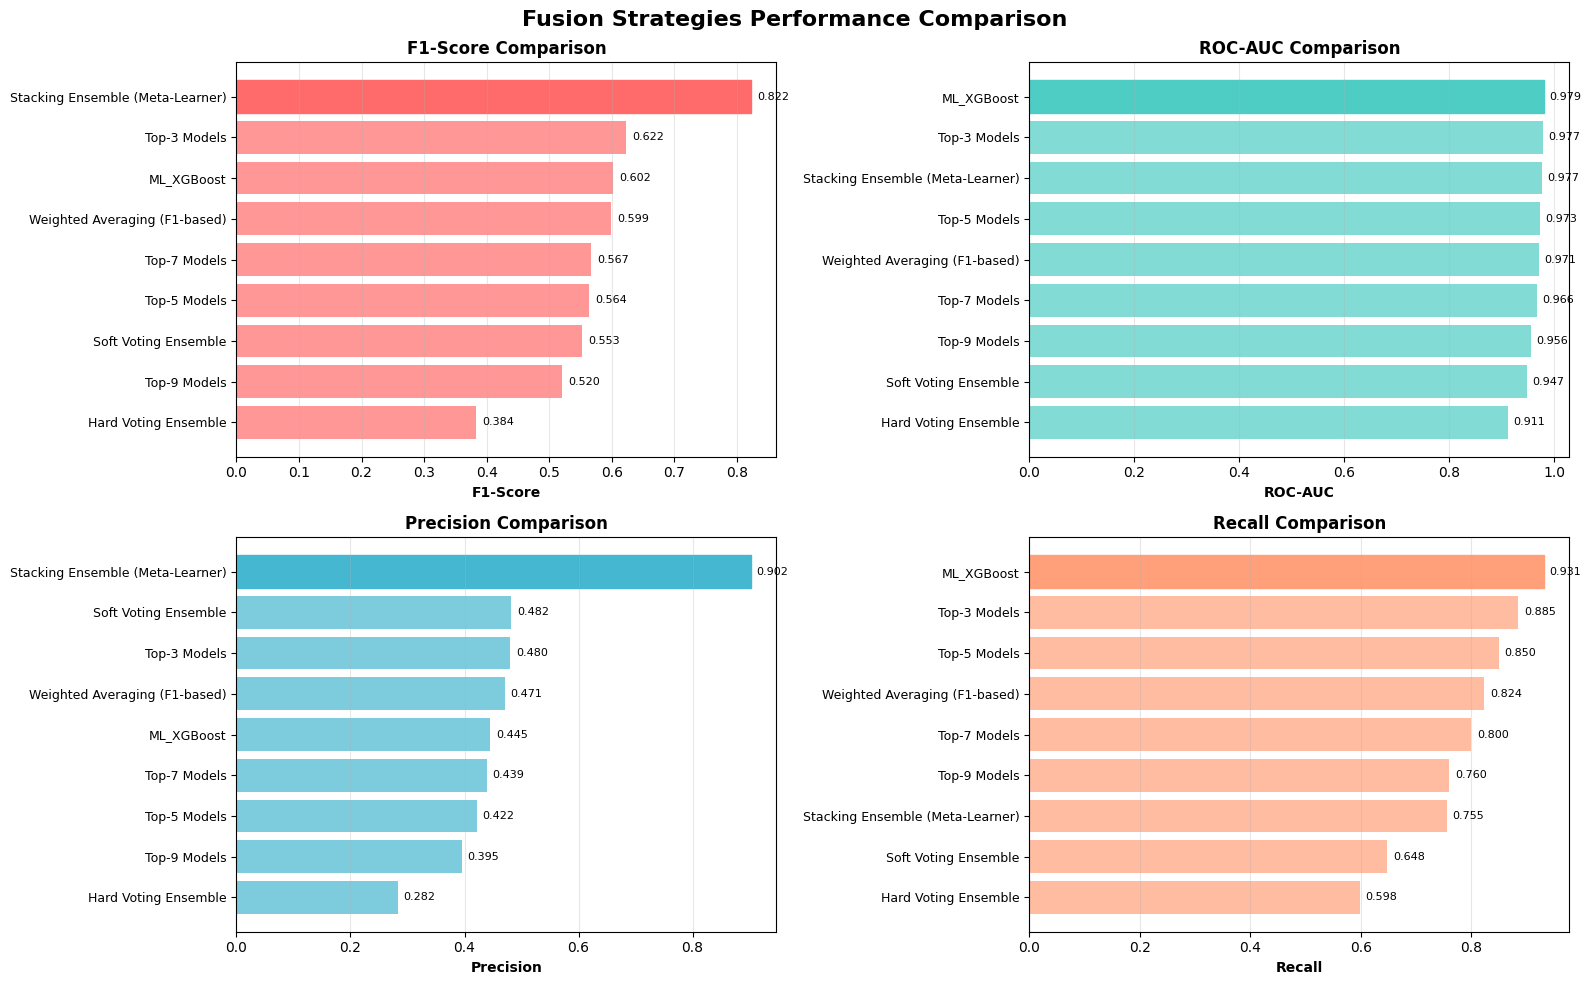

✓ Performance comparison chart created


In [12]:
# Performance comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Fusion Strategies Performance Comparison', fontsize=16, fontweight='bold')

metrics_to_plot = ['F1-Score', 'ROC-AUC', 'Precision', 'Recall']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric
    plot_data = comparison_df.sort_values(metric, ascending=True)
    
    bars = ax.barh(range(len(plot_data)), plot_data[metric], color=color, alpha=0.7)
    
    # Highlight best strategy
    best_idx = plot_data[metric].idxmax()
    bars[list(plot_data.index).index(best_idx)].set_color(color)
    bars[list(plot_data.index).index(best_idx)].set_alpha(1.0)
    
    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels(plot_data['Model'], fontsize=9)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(plot_data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

print("✓ Performance comparison chart created")

## 1️⃣3️⃣ Threshold Optimization

Find the optimal classification threshold for the best fusion strategy to maximize F1-Score.

Threshold Optimization for Best Strategy

Default threshold (0.5):
  F1-Score: 0.8221

Optimal threshold (0.500):
  F1-Score: 0.8221
  Precision: 0.9018
  Recall: 0.7554

📈 Improvement: +0.00%


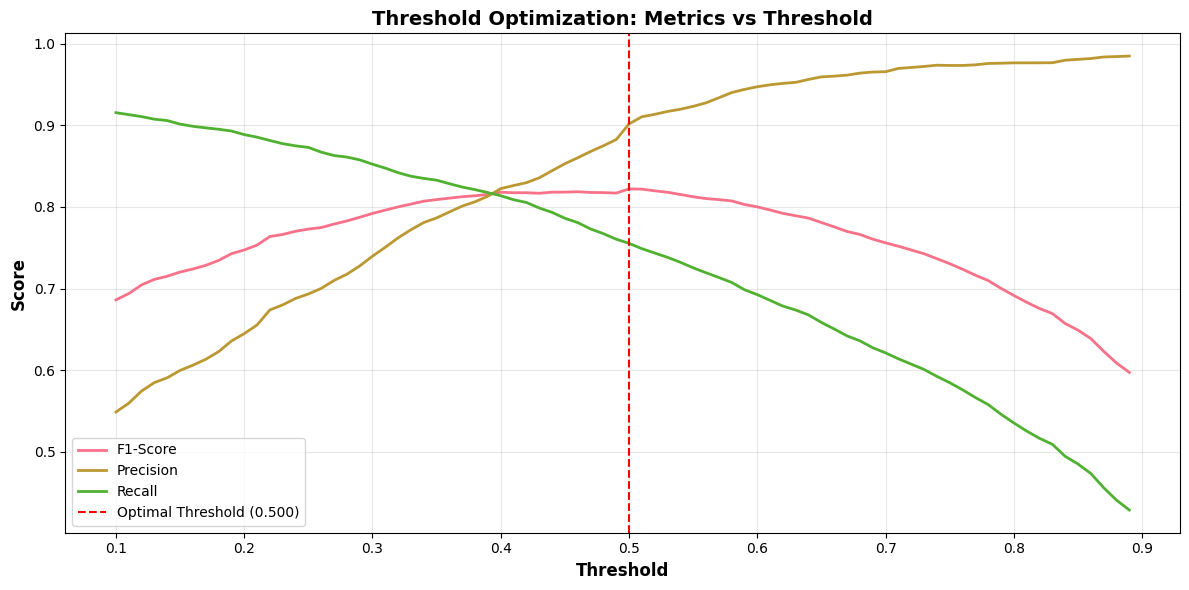


✓ Optimal threshold found: 0.500


In [13]:
print(f"{'='*60}")
print(f"Threshold Optimization for Best Strategy")
print(f"{'='*60}\n")

# Get predictions from best strategy (assuming it's stacking for now - will be determined at runtime)
# This will use the actual best strategy determined above
best_strategy_name = best_strategy['Model']

# Get the corresponding predictions
if 'Stacking' in best_strategy_name:
    best_proba = stacking_proba
elif 'Weighted' in best_strategy_name:
    best_proba = weighted_proba
elif 'Soft Voting' in best_strategy_name:
    best_proba = soft_voting_proba
elif 'Hard Voting' in best_strategy_name:
    best_proba = hard_voting_proba
elif 'Top-' in best_strategy_name:
    # Re-generate for the best Top-K
    k = int(best_strategy_name.split('-')[1].split()[0])
    top_k_models = baseline_df.head(k)['Model'].tolist()
    best_proba = predictions_df[top_k_models].mean(axis=1).values
else:
    # Best individual model
    best_proba = predictions_df[best_strategy_name].values

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
threshold_metrics = []

for threshold in thresholds:
    y_pred = (best_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    
    threshold_metrics.append({
        'Threshold': threshold,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    })

# Find optimal threshold
threshold_df = pd.DataFrame(threshold_metrics)
optimal_idx = threshold_df['F1-Score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'Threshold']
optimal_f1 = threshold_df.loc[optimal_idx, 'F1-Score']

print(f"Default threshold (0.5):")
print(f"  F1-Score: {best_strategy['F1-Score']:.4f}")

print(f"\nOptimal threshold ({optimal_threshold:.3f}):")
print(f"  F1-Score: {optimal_f1:.4f}")
print(f"  Precision: {threshold_df.loc[optimal_idx, 'Precision']:.4f}")
print(f"  Recall: {threshold_df.loc[optimal_idx, 'Recall']:.4f}")

improvement_pct = ((optimal_f1 - best_strategy['F1-Score']) / best_strategy['F1-Score']) * 100
print(f"\n📈 Improvement: +{improvement_pct:.2f}%")

# Plot threshold vs metrics
plt.figure(figsize=(12, 6))
plt.plot(threshold_df['Threshold'], threshold_df['F1-Score'], label='F1-Score', linewidth=2)
plt.plot(threshold_df['Threshold'], threshold_df['Precision'], label='Precision', linewidth=2)
plt.plot(threshold_df['Threshold'], threshold_df['Recall'], label='Recall', linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.3f})')
plt.xlabel('Threshold', fontweight='bold', fontsize=12)
plt.ylabel('Score', fontweight='bold', fontsize=12)
plt.title('Threshold Optimization: Metrics vs Threshold', fontweight='bold', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Optimal threshold found: {optimal_threshold:.3f}")

## 1️⃣4️⃣ Final Evaluation on Test Set

Apply the best fusion strategy with optimized threshold to the test set for final evaluation.

FINAL EVALUATION ON TEST SET

Generating predictions on test set...

FINAL TEST SET RESULTS
Strategy: Stacking Ensemble (Meta-Learner)
Optimal Threshold: 0.500

Performance Metrics:
  Accuracy:  0.9885
  Precision: 0.9085
  Recall:    0.7471
  F1-Score:  0.8199
  ROC-AUC:   0.9742
  PR-AUC:    0.8801

Confusion Matrix:
  TN: 113,665 | FP: 311
  FN: 1,045 | TP: 3,087


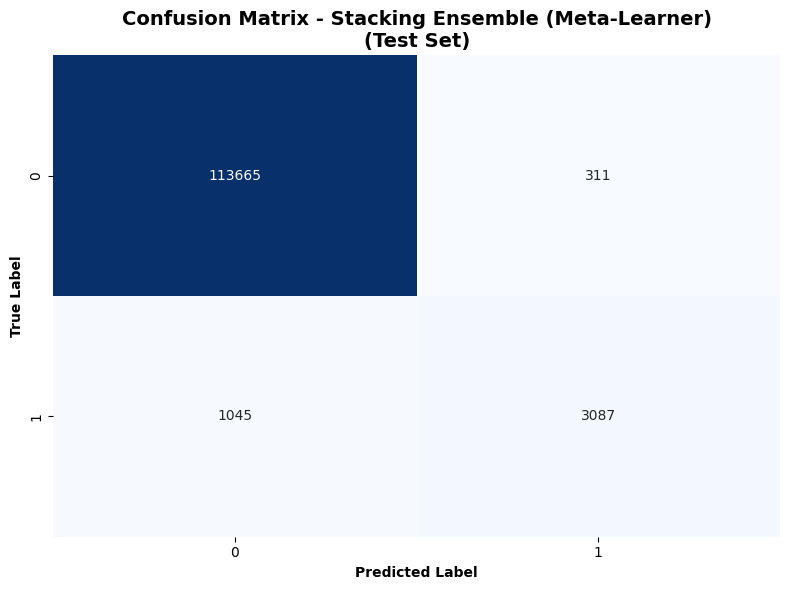


Detailed Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    113976
       Fraud       0.91      0.75      0.82      4132

    accuracy                           0.99    118108
   macro avg       0.95      0.87      0.91    118108
weighted avg       0.99      0.99      0.99    118108


✓ Final evaluation complete!


In [14]:
print(f"{'='*80}")
print(f"FINAL EVALUATION ON TEST SET")
print(f"{'='*80}\n")

# Generate predictions on test set from all base models
print("Generating predictions on test set...")

all_predictions_test = {}

# ML Models
for name, model in ml_models.items():
    X_input = X_test_scaled if name == 'Logistic Regression' else X_test_unscaled
    proba = model.predict_proba(X_input)[:, 1]
    all_predictions_test[f"ML_{name}"] = proba

# DL Models
for name, model in dl_models.items():
    if name == 'Autoencoder':
        reconstructed = model.predict(X_test_scaled, verbose=0)
        reconstruction_error = np.mean((X_test_scaled.values - reconstructed) ** 2, axis=1)
        proba = (reconstruction_error - reconstruction_error.min()) / \
                (reconstruction_error.max() - reconstruction_error.min())
    else:
        proba = model.predict(X_test_scaled, verbose=0).ravel()
    all_predictions_test[f"DL_{name}"] = proba

predictions_test_df = pd.DataFrame(all_predictions_test)

# Apply best strategy on test set
if 'Stacking' in best_strategy_name:
    X_meta_test = predictions_test_df.values
    final_test_proba = best_meta_learner.predict_proba(X_meta_test)[:, 1]
elif 'Weighted' in best_strategy_name:
    final_test_proba = np.zeros(len(y_test))
    for model_name, weight in normalized_weights.items():
        final_test_proba += predictions_test_df[model_name].values * weight
elif 'Soft Voting' in best_strategy_name:
    final_test_proba = predictions_test_df.mean(axis=1).values
elif 'Top-' in best_strategy_name:
    k = int(best_strategy_name.split('-')[1].split()[0])
    top_k_models = baseline_df.head(k)['Model'].tolist()
    final_test_proba = predictions_test_df[top_k_models].mean(axis=1).values
else:
    final_test_proba = predictions_test_df[best_strategy_name].values

# Apply optimal threshold
final_test_pred = (final_test_proba >= optimal_threshold).astype(int)

# Calculate comprehensive metrics
test_accuracy = accuracy_score(y_test, final_test_pred)
test_precision = precision_score(y_test, final_test_pred, zero_division=0)
test_recall = recall_score(y_test, final_test_pred, zero_division=0)
test_f1 = f1_score(y_test, final_test_pred, zero_division=0)
test_roc_auc = roc_auc_score(y_test, final_test_proba)
test_pr_auc = average_precision_score(y_test, final_test_proba)

print(f"\n{'='*80}")
print(f"FINAL TEST SET RESULTS")
print(f"{'='*80}")
print(f"Strategy: {best_strategy_name}")
print(f"Optimal Threshold: {optimal_threshold:.3f}")
print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")
print(f"  PR-AUC:    {test_pr_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, final_test_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix:")
print(f"  TN: {tn:,} | FP: {fp:,}")
print(f"  FN: {fn:,} | TP: {tp:,}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_strategy_name}\n(Test Set)', fontweight='bold', fontsize=14)
plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.tight_layout()
plt.show()

# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, final_test_pred, target_names=['Normal', 'Fraud']))

print(f"\n✓ Final evaluation complete!")

## 1️⃣5️⃣ Save Final Hybrid Ensemble Model

Save the complete ensemble pipeline including meta-learner, weights, threshold, and configuration.

In [15]:
# Create saved_models directory if it doesn't exist
save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

print(f"{'='*60}")
print(f"Saving Final Hybrid Ensemble Model")
print(f"{'='*60}\n")

# Save meta-learner (if stacking was best)
if 'Stacking' in best_strategy_name:
    meta_learner_path = os.path.join(save_dir, 'meta_learner.pkl')
    joblib.dump(best_meta_learner, meta_learner_path)
    print(f"✓ Saved meta-learner: {meta_learner_path}")

# Save model weights (if weighted averaging was best)
if 'Weighted' in best_strategy_name:
    weights_path = os.path.join(save_dir, 'model_weights.pkl')
    joblib.dump(normalized_weights, weights_path)
    print(f"✓ Saved model weights: {weights_path}")

# Save complete configuration
hybrid_config = {
    'strategy': best_strategy_name,
    'optimal_threshold': float(optimal_threshold),
    'validation_metrics': {
        'f1_score': float(best_strategy['F1-Score']),
        'roc_auc': float(best_strategy['ROC-AUC']),
        'precision': float(best_strategy['Precision']),
        'recall': float(best_strategy['Recall'])
    },
    'test_metrics': {
        'accuracy': float(test_accuracy),
        'precision': float(test_precision),
        'recall': float(test_recall),
        'f1_score': float(test_f1),
        'roc_auc': float(test_roc_auc),
        'pr_auc': float(test_pr_auc)
    },
    'confusion_matrix': {
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'tp': int(tp)
    },
    'model_files': {
        'ml_models': ml_model_files,
        'dl_models': dl_model_files
    },
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

config_path = os.path.join(save_dir, 'hybrid_ensemble_config.pkl')
joblib.dump(hybrid_config, config_path)
print(f"✓ Saved configuration: {config_path}")

# Save comparison results
comparison_path = os.path.join(save_dir, 'strategy_comparison.csv')
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Saved comparison results: {comparison_path}")

print(f"\n{'='*60}")
print(f"✓ All components saved successfully!")
print(f"{'='*60}")

Saving Final Hybrid Ensemble Model

✓ Saved meta-learner: saved_models\meta_learner.pkl
✓ Saved configuration: saved_models\hybrid_ensemble_config.pkl
✓ Saved comparison results: saved_models\strategy_comparison.csv

✓ All components saved successfully!


---

## 🎯 Final Summary

Review the complete hybrid ensemble pipeline results.

In [16]:
print(f"\n{'='*80}")
print(f"🎯 HYBRID FRAUD SHIELD - FINAL SUMMARY")
print(f"{'='*80}\n")

print(f"📊 Dataset:")
print(f"  Total samples: {len(df):,}")
print(f"  Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Fraud rate: {df['isFraud'].mean()*100:.2f}%")

print(f"\n🤖 Base Models:")
print(f"  ML Models: {len(ml_models)} (LR, RF, XGBoost, CatBoost, LightGBM)")
print(f"  DL Models: {len(dl_models)} (FNN, CNN, LSTM, BiLSTM, Hybrid, Autoencoder)")
print(f"  Total: {len(ml_models) + len(dl_models)} models")

print(f"\n🔀 Fusion Strategies Tested:")
print(f"  1. Hard Voting (Majority vote)")
print(f"  2. Soft Voting (Average probabilities)")
print(f"  3. Weighted Averaging (F1-based weights)")
print(f"  4. Stacking Ensemble (Meta-learner)")
print(f"  5. Top-K Selection (K=3,5,7,9)")

print(f"\n🏆 Best Strategy: {best_strategy_name}")
print(f"  Optimal Threshold: {optimal_threshold:.3f}")

print(f"\n📈 Validation Performance:")
print(f"  F1-Score:  {best_strategy['F1-Score']:.4f}")
print(f"  ROC-AUC:   {best_strategy['ROC-AUC']:.4f}")
print(f"  Precision: {best_strategy['Precision']:.4f}")
print(f"  Recall:    {best_strategy['Recall']:.4f}")

print(f"\n🎯 Test Set Performance (Final):")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")

print(f"\n📊 Confusion Matrix (Test Set):")
print(f"  True Negatives:  {tn:,}")
print(f"  False Positives: {fp:,}")
print(f"  False Negatives: {fn:,}")
print(f"  True Positives:  {tp:,}")

if best_strategy_name != best_individual_model:
    improvement = ((test_f1 - best_individual_f1) / best_individual_f1) * 100
    print(f"\n✨ Improvement over best individual model:")
    print(f"  Best Individual: {best_individual_model} (F1: {best_individual_f1:.4f})")
    print(f"  Hybrid Ensemble: {best_strategy_name} (F1: {test_f1:.4f})")
    print(f"  Gain: +{improvement:.2f}%")

print(f"\n💾 Saved Files:")
print(f"  - Meta-learner / Weights")
print(f"  - Hybrid configuration")
print(f"  - Strategy comparison")
print(f"  - All in: {save_dir}/")

print(f"\n{'='*80}")
print(f"✅ HYBRID FUSION ENSEMBLE COMPLETE!")
print(f"{'='*80}\n")

print(f"🚀 Next Steps:")
print(f"  1. Review ROC/PR curves and confusion matrices")
print(f"  2. Analyze misclassified cases for insights")
print(f"  3. Deploy best strategy to production")
print(f"  4. Monitor performance on live data")
print(f"  5. Retrain periodically with new data")


🎯 HYBRID FRAUD SHIELD - FINAL SUMMARY

📊 Dataset:
  Total samples: 590,540
  Train: 354,324 | Val: 118,108 | Test: 118,108
  Features: 71
  Fraud rate: 3.50%

🤖 Base Models:
  ML Models: 5 (LR, RF, XGBoost, CatBoost, LightGBM)
  DL Models: 6 (FNN, CNN, LSTM, BiLSTM, Hybrid, Autoencoder)
  Total: 11 models

🔀 Fusion Strategies Tested:
  1. Hard Voting (Majority vote)
  2. Soft Voting (Average probabilities)
  3. Weighted Averaging (F1-based weights)
  4. Stacking Ensemble (Meta-learner)
  5. Top-K Selection (K=3,5,7,9)

🏆 Best Strategy: Stacking Ensemble (Meta-Learner)
  Optimal Threshold: 0.500

📈 Validation Performance:
  F1-Score:  0.8221
  ROC-AUC:   0.9768
  Precision: 0.9018
  Recall:    0.7554

🎯 Test Set Performance (Final):
  Accuracy:  0.9885
  F1-Score:  0.8199
  ROC-AUC:   0.9742
  Precision: 0.9085
  Recall:    0.7471

📊 Confusion Matrix (Test Set):
  True Negatives:  113,665
  False Positives: 311
  False Negatives: 1,045
  True Positives:  3,087

✨ Improvement over best 